In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

In [2]:
# Load data
games = pd.read_csv("data/MRegularSeasonCompactResults.csv")  
seeds = pd.read_csv("data/MNCAATourneySeeds.csv")
rankings = pd.read_csv("data/MMasseyOrdinals.csv")
teams = pd.read_csv("data/MTeams.csv")
game_details = pd.read_csv("data/MRegularSeasonDetailedResults.csv") # collect offensive/defensive rebounds and 3 pointers WFGM3

In [3]:
# Filter and train on 2024 season
season = 2024
games = games[games["Season"] == season]
# First filter for the season and DayNum < 100
rankings = rankings[(rankings["Season"] == season) & (rankings["RankingDayNum"] < 100)]
# For each TeamID and SystemName combination, get the ranking with max DayNum (closest to 100)
rankings = rankings.loc[rankings.groupby(["TeamID", "SystemName"])["RankingDayNum"].idxmax()]

In [4]:
seeds = seeds[seeds["Season"] == season]

In [5]:
# Verify the filtering worked
print("Number of games for 2024:", len(games))
print("Number of seeds for 2024:", len(seeds))

Number of games for 2024: 5607
Number of seeds for 2024: 68


In [6]:
# Extract numeric seed value
seeds["SeedValue"] = seeds["Seed"].str.extract("(\d+)").astype(float)

In [7]:
print(seeds.head(25))

      Season Seed  TeamID  SeedValue
2490    2024  W01    1163        1.0
2491    2024  W02    1235        2.0
2492    2024  W03    1228        3.0
2493    2024  W04    1120        4.0
2494    2024  W05    1361        5.0
2495    2024  W06    1140        6.0
2496    2024  W07    1450        7.0
2497    2024  W08    1194        8.0
2498    2024  W09    1321        9.0
2499    2024  W10    1179       10.0
2500    2024  W11    1182       11.0
2501    2024  W12    1412       12.0
2502    2024  W13    1463       13.0
2503    2024  W14    1287       14.0
2504    2024  W15    1355       15.0
2505    2024  W16    1391       16.0
2506    2024  X01    1314        1.0
2507    2024  X02    1112        2.0
2508    2024  X03    1124        3.0
2509    2024  X04    1104        4.0
2510    2024  X05    1388        5.0
2511    2024  X06    1155        6.0
2512    2024  X07    1173        7.0
2513    2024  X08    1280        8.0
2514    2024  X09    1277        9.0


In [19]:
# Define the preferred ranking systems
preferred_systems = ["SAG", "TPR", "MAS", "RDT", "ESR", "POM", "USA", "AP"]

# Create pivot table with all available rankings from preferred systems
rankings_pivot = rankings.pivot(index="TeamID", columns="SystemName", values="OrdinalRank")

# Filter for only the available preferred systems
available_systems = [sys for sys in preferred_systems if sys in rankings_pivot.columns]

# Create the final pivot table with only available systems
rankings_pivot = rankings_pivot[available_systems]

# Normalize rankings to 0-1 scale where 1 is best
for column in rankings_pivot.columns:
    max_rank = rankings_pivot[column].max()
    rankings_pivot[column] = 1 - (rankings_pivot[column] - 1) / (max_rank - 1)

In [20]:
print(rankings_pivot.head(25))

SystemName       TPR       MAS       ESR       POM       USA        AP
TeamID                                                                
1101        0.362881  0.365651  0.227778  0.354571       NaN       NaN
1102        0.401662  0.360111  0.250000  0.387812       NaN       NaN
1103        0.720222  0.759003  0.780556  0.750693       NaN       NaN
1104        0.980609  0.980609  0.966667  0.983380  0.375000  0.375000
1105        0.011080  0.036011  0.044444  0.041551       NaN       NaN
1106        0.216066  0.141274  0.355556  0.193906       NaN       NaN
1107        0.207756  0.238227  0.344444  0.260388       NaN       NaN
1108        0.113573  0.108033  0.163889  0.152355       NaN       NaN
1110        0.243767  0.279778  0.347222  0.252078       NaN       NaN
1111        0.822715  0.728532  0.833333  0.764543       NaN       NaN
1112        0.986150  0.988920  0.972222  0.991690  0.708333  0.708333
1113        0.662050  0.750693  0.683333  0.648199       NaN       NaN
1114  

In [21]:

# Merge seeds and rankings into team features
team_features = seeds.merge(rankings_pivot, on="TeamID", how="left").fillna(100)  # Fill missing ranks with worst value


In [22]:
print(team_features.head(25))

    Season Seed  TeamID  SeedValue       TPR       MAS       ESR       POM  \
0     2024  W01    1163        1.0  1.000000  0.997230  0.997222  0.994460   
1     2024  W02    1235        2.0  0.958449  0.961219  0.950000  0.963989   
2     2024  W03    1228        3.0  0.975069  0.969529  0.958333  0.975069   
3     2024  W04    1120        4.0  0.983380  0.975069  0.961111  0.988920   
4     2024  W05    1361        5.0  0.933518  0.944598  0.947222  0.947368   
5     2024  W06    1140        6.0  0.963989  0.952909  0.933333  0.977839   
6     2024  W07    1450        7.0  0.891967  0.864266  0.886111  0.883657   
7     2024  W08    1194        8.0  0.952909  0.916898  0.944444  0.939058   
8     2024  W09    1321        9.0  0.903047  0.886427  0.916667  0.867036   
9     2024  W10    1179       10.0  0.861496  0.814404  0.797222  0.853186   
10    2024  W11    1182       11.0  0.703601  0.678670  0.708333  0.714681   
11    2024  W12    1412       12.0  0.700831  0.734072  0.722222

In [23]:
# Function to get last 5 games' win rate
def get_last_n_games_win_rate(team_id, day_num, n=10):
    recent_games = games[((games["WTeamID"] == team_id) | (games["LTeamID"] == team_id)) & (games["DayNum"] < day_num)]
    recent_games = recent_games.tail(n)
    wins = (recent_games["WTeamID"] == team_id).sum()
    return wins / n if len(recent_games) > 0 else 0.5  # Default to 50% if no games

# Get list of teams we have features for
valid_teams = set(team_features["TeamID"].unique())

# Filter games to only include teams we have features for
games = games[
    games["WTeamID"].isin(valid_teams) & 
    games["LTeamID"].isin(valid_teams)
]

# Compute last 3 games' win rate for each team
team_features["Last5WinRate"] = team_features["TeamID"].apply(lambda team: 
                                                              get_last_n_games_win_rate(team, 100)) 



In [24]:
print(team_features.head(25))

    Season Seed  TeamID  SeedValue       TPR       MAS       ESR       POM  \
0     2024  W01    1163        1.0  1.000000  0.997230  0.997222  0.994460   
1     2024  W02    1235        2.0  0.958449  0.961219  0.950000  0.963989   
2     2024  W03    1228        3.0  0.975069  0.969529  0.958333  0.975069   
3     2024  W04    1120        4.0  0.983380  0.975069  0.961111  0.988920   
4     2024  W05    1361        5.0  0.933518  0.944598  0.947222  0.947368   
5     2024  W06    1140        6.0  0.963989  0.952909  0.933333  0.977839   
6     2024  W07    1450        7.0  0.891967  0.864266  0.886111  0.883657   
7     2024  W08    1194        8.0  0.952909  0.916898  0.944444  0.939058   
8     2024  W09    1321        9.0  0.903047  0.886427  0.916667  0.867036   
9     2024  W10    1179       10.0  0.861496  0.814404  0.797222  0.853186   
10    2024  W11    1182       11.0  0.703601  0.678670  0.708333  0.714681   
11    2024  W12    1412       12.0  0.700831  0.734072  0.722222

In [25]:
# Extract last game for each team in 2024 (after DayNum 100)
games_2024 = games[(games['Season'] == 2024) & (games['DayNum'] > 100)]
last_games = games_2024.sort_values('DayNum', ascending=False).drop_duplicates(subset=['WTeamID', 'LTeamID'])

# Convert last game results into matchup format, including both win and loss perspectives
matchups_win = last_games[['Season', 'WTeamID', 'LTeamID']].copy()
matchups_win['Win'] = 1
matchups_win.columns = ['Season', 'Team1', 'Team2', 'Win']

matchups_loss = last_games[['Season', 'LTeamID', 'WTeamID']].copy()
matchups_loss['Win'] = 0
matchups_loss.columns = ['Season', 'Team1', 'Team2', 'Win']

# Combine both perspectives
matchups = pd.concat([matchups_win, matchups_loss], ignore_index=True)

# Rest of your code remains the same...

In [26]:
print(matchups.head(25))

    Season  Team1  Team2  Win
0     2024   1228   1458    1
1     2024   1120   1196    1
2     2024   1235   1222    1
3     2024   1120   1280    1
4     2024   1163   1266    1
5     2024   1196   1401    1
6     2024   1228   1304    1
7     2024   1301   1314    1
8     2024   1307   1361    1
9     2024   1332   1160    1
10    2024   1458   1345    1
11    2024   1301   1438    1
12    2024   1120   1376    1
13    2024   1160   1450    1
14    2024   1222   1403    1
15    2024   1235   1124    1
16    2024   1280   1397    1
17    2024   1196   1104    1
18    2024   1307   1161    1
19    2024   1345   1277    1
20    2024   1361   1429    1
21    2024   1332   1112    1
22    2024   1401   1246    1
23    2024   1458   1321    1
24    2024   1161   1305    1


In [27]:
# First, calculate home/away win rates and add to team_features
def add_location_performance(team_features, games):
    for idx, row in team_features.iterrows():
        team_id = row['TeamID']
        team_games = games[(games['WTeamID'] == team_id) | (games['LTeamID'] == team_id)]
        
        # Home performance
        home_games = team_games[
            ((team_games['WTeamID'] == team_id) & (team_games['WLoc'] == 'H')) |
            ((team_games['LTeamID'] == team_id) & (team_games['WLoc'] == 'A'))
        ]
        home_wins = len(home_games[home_games['WTeamID'] == team_id])
        home_games_count = len(home_games)
        
        # Away performance
        away_games = team_games[
            ((team_games['WTeamID'] == team_id) & (team_games['WLoc'] == 'A')) |
            ((team_games['LTeamID'] == team_id) & (team_games['WLoc'] == 'H'))
        ]
        away_wins = len(away_games[away_games['WTeamID'] == team_id])
        away_games_count = len(away_games)
        
        # Update team_features
        team_features.loc[idx, 'HomeWinRate'] = home_wins / home_games_count if home_games_count > 0 else 0.5
        team_features.loc[idx, 'AwayWinRate'] = away_wins / away_games_count if away_games_count > 0 else 0.5
    
    return team_features

# Add location performance before creating features
team_features = add_location_performance(team_features, games)

In [28]:
def calculate_enhanced_sos(games_df, team_id, current_day=None):
    if current_day:
        games_df = games_df[games_df['DayNum'] < current_day]
    
    # Constants for weighting
    HOME_ADVANTAGE = 1.2
    AWAY_ADVANTAGE = 1.5
    NEUTRAL_ADVANTAGE = 1.3
    RECENCY_DECAY = 0.95
    
    team_games = games_df[(games_df['WTeamID'] == team_id) | (games_df['LTeamID'] == team_id)]
    team_games = team_games.sort_values('DayNum', ascending=True)
    team_games = team_games.reset_index(drop=True)  # Reset index to 0-based
    
    sos_score = 0
    total_weight = 0
    
    for i, game in team_games.iterrows():
        # Calculate recency weight based on game index
        # More recent games (higher index) get higher weight
        recency_weight = RECENCY_DECAY ** (len(team_games) - i - 1)
        if recency_weight > 1e10:  # Cap the weight if it gets too large
            recency_weight = 1.0
        
        # Determine if team was home/away
        is_home = game['WLoc'] == 'H' if game['WTeamID'] == team_id else game['WLoc'] == 'A'
        is_away = game['WLoc'] == 'A' if game['WTeamID'] == team_id else game['WLoc'] == 'H'
        
        # Get opponent ID
        opponent_id = game['LTeamID'] if game['WTeamID'] == team_id else game['WTeamID']
        
        # Calculate opponent's win rate
        prev_games = games_df[games_df['DayNum'] < game['DayNum']]
        opp_games = prev_games[
            (prev_games['WTeamID'] == opponent_id) | 
            (prev_games['LTeamID'] == opponent_id)
        ]
        
        opp_wins = len(opp_games[opp_games['WTeamID'] == opponent_id])
        opp_total = len(opp_games)
        opp_strength = opp_wins / opp_total if opp_total > 0 else 0.5
        
        # Calculate location weight
        location_weight = (HOME_ADVANTAGE if is_home else 
                         AWAY_ADVANTAGE if is_away else 
                         NEUTRAL_ADVANTAGE)
        
        # Combine weights
        game_weight = min(location_weight * recency_weight, 10.0)  # Cap the combined weight
        
        # Add score differential component
        score_diff = abs(game['WScore'] - game['LScore'])
        max_mov = 30
        mov_multiplier = min(score_diff, max_mov) / max_mov
        
        # Calculate game SOS
        game_sos = opp_strength * (1 + mov_multiplier * 0.2)
        
        sos_score += game_sos * game_weight
        total_weight += game_weight
    
    return sos_score / total_weight if total_weight > 0 else 0.5

def add_location_performance(team_features, games_df):
    print("Adding location performance metrics...")  # Debug print
    
    for idx, row in team_features.iterrows():
        team_id = row['TeamID']
        
        try:
            # Calculate home performance
            home_games = games_df[
                ((games_df['WTeamID'] == team_id) & (games_df['WLoc'] == 'H')) |
                ((games_df['LTeamID'] == team_id) & (games_df['WLoc'] == 'A'))
            ]
            home_wins = len(home_games[home_games['WTeamID'] == team_id])
            home_games_count = len(home_games)
            
            # Calculate away performance
            away_games = games_df[
                ((games_df['WTeamID'] == team_id) & (games_df['WLoc'] == 'A')) |
                ((games_df['LTeamID'] == team_id) & (games_df['WLoc'] == 'H'))
            ]
            away_wins = len(away_games[away_games['WTeamID'] == team_id])
            away_games_count = len(away_games)
            
            # Update metrics
            team_features.loc[idx, 'HomeWinRate'] = home_wins / home_games_count if home_games_count > 0 else 0.5
            team_features.loc[idx, 'AwayWinRate'] = away_wins / away_games_count if away_games_count > 0 else 0.5
            
            # Calculate SOS
            sos = calculate_enhanced_sos(games_df, team_id)
            team_features.loc[idx, 'SOS'] = sos
            
            if idx % 50 == 0:  # Print progress every 50 teams
                print(f"Processed {idx} teams...")
                
        except Exception as e:
            print(f"Error processing team {team_id}: {str(e)}")
            team_features.loc[idx, 'HomeWinRate'] = 0.5
            team_features.loc[idx, 'AwayWinRate'] = 0.5
            team_features.loc[idx, 'SOS'] = 0.5
    
    print("Finished adding location performance metrics.")
    return team_features

# Use in your model preparation
team_features = add_location_performance(team_features, games)

Adding location performance metrics...
Processed 0 teams...
Processed 50 teams...
Finished adding location performance metrics.



Top 10 Hardest Schedules:
    TeamID       SOS  HomeWinRate  AwayWinRate
13    1287  0.907692     0.500000     0.000000
47    1103  0.829133     0.500000     0.500000
35    1166  0.762460     1.000000     0.333333
28    1158  0.760333     0.500000     0.000000
11    1412  0.750590     0.666667     0.000000
52    1266  0.741920     0.666667     0.250000
31    1224  0.739238     0.000000     0.000000
29    1159  0.725789     0.500000     0.333333
55    1458  0.681834     0.571429     0.250000
62    1301  0.654623     0.333333     0.333333

Bottom 10 Easiest Schedules:
    TeamID       SOS  HomeWinRate  AwayWinRate
43    1438  0.425828     0.666667     0.333333
7     1194  0.419151     1.000000     0.000000
65    1324  0.399775     0.500000     0.000000
49    1212  0.373521     0.500000     0.000000
30    1253  0.266667     0.500000     0.500000
14    1355  0.253333     0.500000     0.500000
9     1179  0.215900     1.000000     0.000000
64    1436  0.163325     0.500000     0.500000
45 

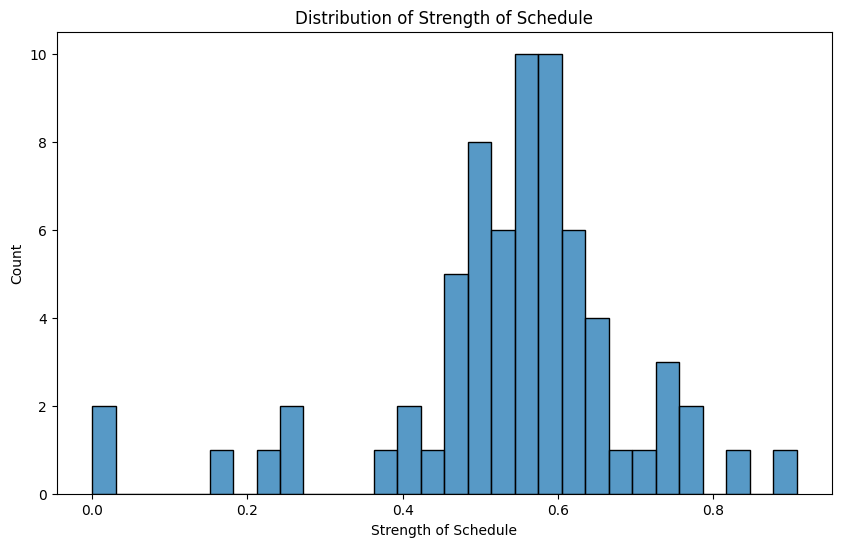

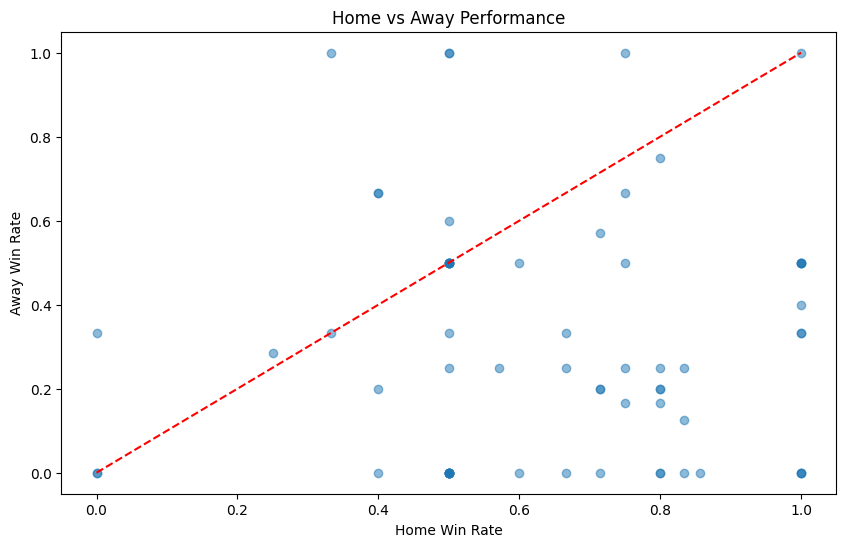

In [29]:
# After calculating SOS, create a readable summary
def print_sos_analysis(team_features):
    # Create a DataFrame with team ID and SOS
    sos_df = team_features[['TeamID', 'SOS', 'HomeWinRate', 'AwayWinRate']].copy()
    
    # Sort by SOS in descending order
    sos_df = sos_df.sort_values('SOS', ascending=False)
    
    # Print top 10 hardest schedules
    print("\nTop 10 Hardest Schedules:")
    print(sos_df.head(10))
    
    # Print bottom 10 easiest schedules
    print("\nBottom 10 Easiest Schedules:")
    print(sos_df.tail(10))
    
    # Print summary statistics
    print("\nSOS Summary Statistics:")
    print(sos_df['SOS'].describe())
    
    # Optional: Save to CSV
    sos_df.to_csv('strength_of_schedule.csv', index=False)
    
    return sos_df

# After calculating team_features
sos_results = print_sos_analysis(team_features)

# If you want to look up specific teams
def lookup_team_sos(team_id, team_features):
    team_info = team_features[team_features['TeamID'] == team_id]
    if not team_info.empty:
        print(f"\nTeam ID: {team_id}")
        print(f"SOS: {team_info['SOS'].values[0]:.3f}")
        print(f"Home Win Rate: {team_info['HomeWinRate'].values[0]:.3f}")
        print(f"Away Win Rate: {team_info['AwayWinRate'].values[0]:.3f}")
    else:
        print(f"Team ID {team_id} not found")

# Example: Look up a specific team
lookup_team_sos(1234, team_features)  # Replace 1234 with actual team ID

# If you want to visualize the distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=team_features, x='SOS', bins=30)
plt.title('Distribution of Strength of Schedule')
plt.xlabel('Strength of Schedule')
plt.ylabel('Count')
plt.show()

# Create a scatter plot of Home vs Away performance
plt.figure(figsize=(10, 6))
plt.scatter(team_features['HomeWinRate'], team_features['AwayWinRate'], alpha=0.5)
plt.xlabel('Home Win Rate')
plt.ylabel('Away Win Rate')
plt.title('Home vs Away Performance')
# Add diagonal line for reference
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [31]:
# Split into train and test
train_games = games[games["DayNum"] <= 100]
test_games = games[games["DayNum"] > 100]

# Check for missing teams
def check_missing_teams(games, team_features):
    game_teams = set(games['WTeamID'].unique()) | set(games['LTeamID'].unique())
    feature_teams = set(team_features['TeamID'])
    missing_teams = game_teams - feature_teams
    if missing_teams:
        print(f"Missing {len(missing_teams)} teams in team_features:")
        print(missing_teams)
    return missing_teams

# Check for missing teams
missing_teams = check_missing_teams(games, team_features)

# Modified feature creation with error handling
train_data = []
for _, row in games.iterrows():
    team1, team2 = row["WTeamID"], row["LTeamID"]
    
    # Check if both teams exist in team_features
    team1_data = team_features[team_features["TeamID"] == team1]
    team2_data = team_features[team_features["TeamID"] == team2]
    
    if team1_data.empty or team2_data.empty:
        print(f"Skipping game: Team1={team1}, Team2={team2} - missing team data")
        continue
        
    team1_features = team1_data.iloc[0]
    team2_features = team2_data.iloc[0]
    
    try:
        features = {
            "Seed_Diff": team1_features["SeedValue"] - team2_features["SeedValue"],
            # Raw normalized rankings for each team
            "Team1_TPR": team1_features["TPR"],
            "Team2_TPR": team2_features["TPR"],
            "Team1_MAS": team1_features["MAS"],
            "Team2_MAS": team2_features["MAS"],
            "Team1_ESR": team1_features["ESR"],
            "Team2_ESR": team2_features["ESR"],
            "Team1_POM": team1_features["POM"],
            "Team2_POM": team2_features["POM"],
            # Differences in rankings
            "Ranking_Diff_TPR": team1_features["TPR"] - team2_features["TPR"],
            "Ranking_Diff_MAS": team1_features["MAS"] - team2_features["MAS"],
            "Ranking_Diff_ESR": team1_features["ESR"] - team2_features["ESR"],
            "Ranking_Diff_POM": team1_features["POM"] - team2_features["POM"],
            "Ranking_Diff_USA": team1_features["USA"] - team2_features["USA"],
            "Ranking_Diff_AP": team1_features["AP"] - team2_features["AP"],
            # Products of rankings
            "Ranking_Prod_TPR": team1_features["TPR"] * team2_features["TPR"],
            "Ranking_Prod_MAS": team1_features["MAS"] * team2_features["MAS"],
            "Ranking_Prod_ESR": team1_features["ESR"] * team2_features["ESR"],
            "Ranking_Prod_POM": team1_features["POM"] * team2_features["POM"],
            "Ranking_Prod_USA": team1_features["USA"] * team2_features["USA"],
            "Ranking_Prod_AP": team1_features["AP"] * team2_features["AP"], 
            # Win rates
            "Last10WinRate_Team1": get_last_n_games_win_rate(team1, row["DayNum"], 10),
            "Last10WinRate_Team2": get_last_n_games_win_rate(team2, row["DayNum"], 10),
            "WinRate_Diff": (get_last_n_games_win_rate(team1, row["DayNum"]) - 
                            get_last_n_games_win_rate(team2, row["DayNum"])),
            "WFGM3_Diff": (game_details[game_details["WTeamID"] == team1]["WFGM3"].sum() - 
                            game_details[game_details["WTeamID"] == team2]["WFGM3"].sum()),
            'SOS_Team1': team1_features["SOS"],
            'SOS_Team2': team2_features["SOS"],
            'SOS_Diff': team1_features["SOS"] - team2_features["SOS"],
            'HomeWinRate_Team1': team1_features["HomeWinRate"],
            'AwayWinRate_Team2': team2_features["AwayWinRate"],
            'HomeAway_Advantage': team1_features["HomeWinRate"] - team2_features["AwayWinRate"],
            "Outcome": 1
        }
        
        # Add squared differences
        features.update({
            "Ranking_Diff_TPR_Squared": features["Ranking_Diff_TPR"] ** 2,
            "Ranking_Diff_MAS_Squared": features["Ranking_Diff_MAS"] ** 2,
            "Ranking_Diff_ESR_Squared": features["Ranking_Diff_ESR"] ** 2,
            "Ranking_Diff_POM_Squared": features["Ranking_Diff_POM"] ** 2,
            "Ranking_Diff_USA_Squared": features["Ranking_Diff_USA"] ** 2,
            "Ranking_Diff_AP_Squared": features["Ranking_Diff_AP"] ** 2,
        })
        
        # Create reverse matchup
        reverse_features = features.copy()
        for key in features.keys():
            if key.startswith("Team1_"):
                reverse_key = key.replace("Team1_", "Team2_")
                reverse_features[key] = features[reverse_key]
                reverse_features[reverse_key] = features[key]
        
        # Negate differences
        for key in features.keys():
            if key.startswith("Ranking_Diff_") and not key.endswith("_Squared"):
                reverse_features[key] = -features[key]
        
        reverse_features["Seed_Diff"] = -features["Seed_Diff"]
        reverse_features["WinRate_Diff"] = -features["WinRate_Diff"]
        reverse_features["WFGM3_Diff"] = -features["WFGM3_Diff"]
        reverse_features["SOS_Diff"] = -features["SOS_Diff"]
        reverse_features["HomeAway_Advantage"] = -features["HomeAway_Advantage"]
        reverse_features["Last10WinRate_Team1"] = features["Last10WinRate_Team2"]
        reverse_features["Last10WinRate_Team2"] = features["Last10WinRate_Team1"]
        reverse_features["Outcome"] = 0
        
        train_data.append(features)
        train_data.append(reverse_features)
        
    except Exception as e:
        print(f"Error processing game: Team1={team1}, Team2={team2}")
        print(f"Error: {str(e)}")
        continue

print(f"Created features for {len(train_data)} games")

# Convert to DataFrame
df_train = pd.DataFrame(train_data)

# Use a more sophisticated model
from sklearn.ensemble import GradientBoostingClassifier

# Train model
X_train = df_train.drop('Outcome', axis=1)
y_train = df_train['Outcome']

model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)



Created features for 608 games


GradientBoostingClassifier()

In [32]:
print(X_train.head(25))

    Seed_Diff  Team1_TPR  Team2_TPR  Team1_MAS  Team2_MAS  Team1_ESR  \
0        -1.0   0.720222   0.537396   0.759003   0.523546   0.780556   
1         1.0   0.537396   0.720222   0.523546   0.759003   0.402778   
2       -10.0   0.980609   0.592798   0.980609   0.648199   0.966667   
3        10.0   0.592798   0.980609   0.648199   0.980609   0.750000   
4         3.0   0.844875   0.955679   0.800554   0.925208   0.861111   
5        -3.0   0.955679   0.844875   0.925208   0.800554   0.891667   
6       -12.0   0.997230   0.731302   1.000000   0.761773   1.000000   
7        12.0   0.731302   0.997230   0.761773   1.000000   0.858333   
8        -1.0   0.961219   0.983380   0.972299   0.975069   0.969444   
9         1.0   0.983380   0.961219   0.975069   0.972299   0.961111   
10       -6.0   0.886427   0.950139   0.914127   0.908587   0.850000   
11        6.0   0.950139   0.886427   0.908587   0.914127   0.888889   
12       -2.0   0.986150   0.969529   0.988920   0.966759   0.97

In [33]:
# Train the model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Print model performance
y_pred = model.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_pred))

# Look at feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': abs(model.coef_[0])
})
print("\nFeature Importance:")
print(feature_importance.sort_values('Importance', ascending=False))

Training Accuracy: 0.7236842105263158

Feature Importance:
                     Feature    Importance
30        HomeAway_Advantage  7.966910e-01
0                  Seed_Diff  1.099003e-01
23              WinRate_Diff  6.948190e-02
9           Ranking_Diff_TPR  3.578261e-02
21       Last10WinRate_Team1  3.474099e-02
22       Last10WinRate_Team2  3.474091e-02
11          Ranking_Diff_ESR  3.397750e-02
12          Ranking_Diff_POM  3.273800e-02
10          Ranking_Diff_MAS  3.148314e-02
2                  Team2_TPR  1.789136e-02
1                  Team1_TPR  1.789126e-02
6                  Team2_ESR  1.698879e-02
5                  Team1_ESR  1.698870e-02
8                  Team2_POM  1.636906e-02
7                  Team1_POM  1.636894e-02
4                  Team2_MAS  1.574164e-02
3                  Team1_MAS  1.574150e-02
14           Ranking_Diff_AP  7.649517e-03
13          Ranking_Diff_USA  5.061174e-03
27                  SOS_Diff  1.217473e-03
20           Ranking_Prod_AP  2.319207

/Users/erinyepis/opt/anaconda3/envs/dbt-local-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
print(matchups.head(25))

    Season  Team1  Team2  Win
0     2024   1228   1458    1
1     2024   1120   1196    1
2     2024   1235   1222    1
3     2024   1120   1280    1
4     2024   1163   1266    1
5     2024   1196   1401    1
6     2024   1228   1304    1
7     2024   1301   1314    1
8     2024   1307   1361    1
9     2024   1332   1160    1
10    2024   1458   1345    1
11    2024   1301   1438    1
12    2024   1120   1376    1
13    2024   1160   1450    1
14    2024   1222   1403    1
15    2024   1235   1124    1
16    2024   1280   1397    1
17    2024   1196   1104    1
18    2024   1307   1161    1
19    2024   1345   1277    1
20    2024   1361   1429    1
21    2024   1332   1112    1
22    2024   1401   1246    1
23    2024   1458   1321    1
24    2024   1161   1305    1


In [36]:
# Prepare test data with same features
test_data = []
test_labels = []

# Get the last known DayNum from the games DataFrame instead
last_day = games['DayNum'].max()  # Using games DataFrame instead of train_data list

for _, row in matchups.iterrows():
    team1, team2 = row["Team1"], row["Team2"]
    
    # Create a new row dictionary with DayNum
    row = row.copy()  # Create a copy to avoid modifying original data
    row["DayNum"] = last_day  # Add the last_day to the row
    
    if team1 in team_features["TeamID"].values and team2 in team_features["TeamID"].values:
        team1_features = team_features[team_features["TeamID"] == team1].iloc[0]
        team2_features = team_features[team_features["TeamID"] == team2].iloc[0]
        
        features = {
            "Seed_Diff": team1_features["SeedValue"] - team2_features["SeedValue"],
            # Raw normalized rankings for each team
            "Team1_TPR": team1_features["TPR"],
            "Team2_TPR": team2_features["TPR"],
            "Team1_MAS": team1_features["MAS"],
            "Team2_MAS": team2_features["MAS"],
            "Team1_ESR": team1_features["ESR"],
            "Team2_ESR": team2_features["ESR"],
            "Team1_POM": team1_features["POM"],
            "Team2_POM": team2_features["POM"],
            # Differences in rankings
            "Ranking_Diff_TPR": team1_features["TPR"] - team2_features["TPR"],
            "Ranking_Diff_MAS": team1_features["MAS"] - team2_features["MAS"],
            "Ranking_Diff_ESR": team1_features["ESR"] - team2_features["ESR"],
            "Ranking_Diff_POM": team1_features["POM"] - team2_features["POM"],
            "Ranking_Diff_USA": team1_features["USA"] - team2_features["USA"],
            "Ranking_Diff_AP": team1_features["AP"] - team2_features["AP"],
            # Products of rankings
            "Ranking_Prod_TPR": team1_features["TPR"] * team2_features["TPR"],
            "Ranking_Prod_MAS": team1_features["MAS"] * team2_features["MAS"],
            "Ranking_Prod_ESR": team1_features["ESR"] * team2_features["ESR"],
            "Ranking_Prod_POM": team1_features["POM"] * team2_features["POM"],      
            "Ranking_Prod_USA": team1_features["USA"] * team2_features["USA"],
            "Ranking_Prod_AP": team1_features["AP"] * team2_features["AP"],
            # Win rates
            "Last10WinRate_Team1": get_last_n_games_win_rate(team1, row["DayNum"], 10),
            "Last10WinRate_Team2": get_last_n_games_win_rate(team2, row["DayNum"]),
            "WinRate_Diff": (get_last_n_games_win_rate(team1, row["DayNum"]) - 
                            get_last_n_games_win_rate(team2, row["DayNum"])),
            "WFGM3_Diff": (game_details[game_details["WTeamID"] == team1]["WFGM3"].sum() - 
                            game_details[game_details["WTeamID"] == team2]["WFGM3"].sum()),
            'SOS_Team1': team1_features["SOS"],
            'SOS_Team2': team2_features["SOS"],
            'SOS_Diff': team1_features["SOS"] - team2_features["SOS"],
            'HomeWinRate_Team1': team1_features["HomeWinRate"],
            'AwayWinRate_Team2': team2_features["AwayWinRate"],
            'HomeAway_Advantage': team1_features["HomeWinRate"] - team2_features["AwayWinRate"],
            "Outcome": 1
        }
        
        # Add squared differences
        features.update({
            "Ranking_Diff_TPR_Squared": features["Ranking_Diff_TPR"] ** 2,
            "Ranking_Diff_MAS_Squared": features["Ranking_Diff_MAS"] ** 2,
            "Ranking_Diff_ESR_Squared": features["Ranking_Diff_ESR"] ** 2,
            "Ranking_Diff_POM_Squared": features["Ranking_Diff_POM"] ** 2,
            "Ranking_Diff_USA_Squared": features["Ranking_Diff_USA"] ** 2,
            "Ranking_Diff_AP_Squared": features["Ranking_Diff_AP"] ** 2,
        })
        
        test_data.append(features)
        test_labels.append(row["Win"]) 

# Make predictions
df_test = pd.DataFrame(test_data)
X_test = df_test[X_train.columns]
y_test = np.array(test_labels)  # Add this line to create y_test

predictions = model.predict_proba(X_test)
predicted_wins = predictions[:, 1]

# Print results
print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, predicted_wins > 0.5))
if len(np.unique(y_test)) > 1:
    print("Log Loss:", log_loss(y_test, predicted_wins))


Model Performance:
Accuracy: 0.6488095238095238
Log Loss: 0.6834501181179298



Model Performance:
Training Accuracy: 0.7236842105263158
Test Accuracy: 0.6488095238095238

Sample Predictions vs Actuals:
   Team1  Team2  Win  Predicted_Win_Prob
0   1228   1458    1            0.645217
1   1120   1196    1            0.398753
2   1235   1222    1            0.577585
3   1120   1280    1            0.741743
4   1163   1266    1            0.669408
5   1196   1401    1            0.882412
6   1228   1304    1            0.440781
7   1301   1314    1            0.403203
8   1307   1361    1            0.464250
9   1332   1160    1            0.707640

Detailed Prediction Analysis:
              precision    recall  f1-score   support

        Loss       0.69      0.54      0.60        84
         Win       0.62      0.76      0.68        84

    accuracy                           0.65       168
   macro avg       0.66      0.65      0.64       168
weighted avg       0.66      0.65      0.64       168


Examples of Incorrect Predictions:
    Team1  Team2  Win  Predicte

/var/folders/gc/_00hl__j42163556kvkzz4b40000gq/T/ipykernel_91188/3539835006.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_predictions['Confidence'] = np.where(


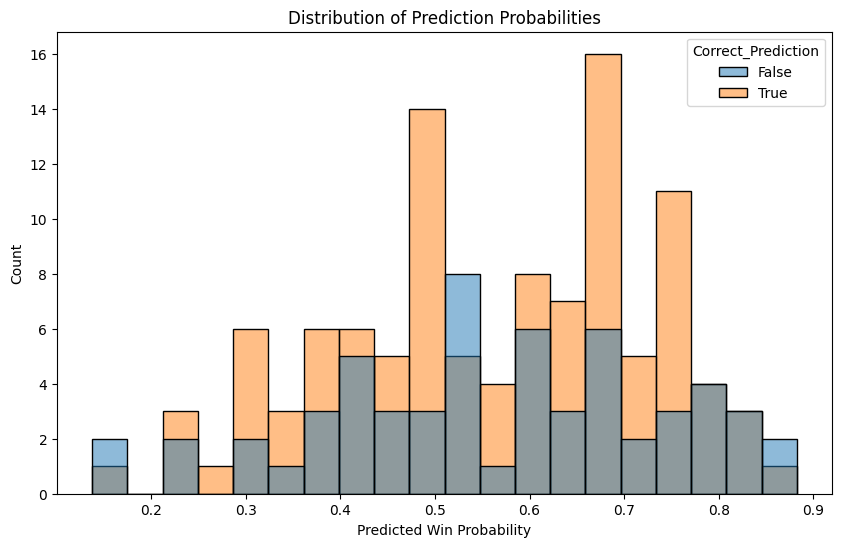


Accuracy by Confidence Level:
                 Correct_Prediction       
                              count   mean
Confidence_Level                          
50-60%                           56  0.625
60-70%                           66  0.697
70-80%                           33  0.667
80-90%                           13  0.462
90-100%                           0    NaN


/var/folders/gc/_00hl__j42163556kvkzz4b40000gq/T/ipykernel_91188/3539835006.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  confidence_accuracy = analysis_df.groupby('Confidence_Level').agg({


In [37]:
# Make predictions
df_test = pd.DataFrame(test_data)
X_test = df_test[X_train.columns]
predictions = model.predict_proba(X_test)
predicted_wins = predictions[:, 1]

# Add predictions back to the matchups DataFrame
matchups['Predicted_Win_Prob'] = predicted_wins

# Calculate accuracy using actual outcomes from matchups
actual_outcomes = matchups['Win'].values
predicted_outcomes = (predicted_wins > 0.5).astype(int)

print("\nModel Performance:")
print("Training Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", accuracy_score(actual_outcomes, predicted_outcomes))
print("\nSample Predictions vs Actuals:")
print(matchups[['Team1', 'Team2', 'Win', 'Predicted_Win_Prob']].head(10))

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix with labels
cm = confusion_matrix(actual_outcomes, predicted_outcomes)
labels = ['Loss', 'Win']

# Create a more detailed analysis
print("\nDetailed Prediction Analysis:")
print(classification_report(actual_outcomes, predicted_outcomes, target_names=labels))

# Create a DataFrame with actual and predicted results
analysis_df = matchups.copy()
analysis_df['Predicted_Outcome'] = (predicted_wins > 0.5).astype(int)
analysis_df['Correct_Prediction'] = analysis_df['Win'] == analysis_df['Predicted_Outcome']

# Show examples of incorrect predictions
print("\nExamples of Incorrect Predictions:")
incorrect_predictions = analysis_df[~analysis_df['Correct_Prediction']]
print(incorrect_predictions[['Team1', 'Team2', 'Win', 'Predicted_Win_Prob', 'Predicted_Outcome']].head(10))

# Show most confident incorrect predictions
print("\nMost Confident Incorrect Predictions:")
incorrect_predictions['Confidence'] = np.where(
    incorrect_predictions['Predicted_Win_Prob'] > 0.5,
    incorrect_predictions['Predicted_Win_Prob'],
    1 - incorrect_predictions['Predicted_Win_Prob']
)
print(incorrect_predictions.sort_values('Confidence', ascending=False)[
    ['Team1', 'Team2', 'Win', 'Predicted_Win_Prob', 'Predicted_Outcome']
].head(10))

# Visualize prediction confidence distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=analysis_df, x='Predicted_Win_Prob', hue='Correct_Prediction', bins=20)
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Predicted Win Probability')
plt.ylabel('Count')
plt.show()

# Calculate accuracy by confidence level
analysis_df['Confidence_Level'] = pd.cut(
    np.where(analysis_df['Predicted_Win_Prob'] > 0.5, 
             analysis_df['Predicted_Win_Prob'], 
             1 - analysis_df['Predicted_Win_Prob']),
    bins=[0, 0.6, 0.7, 0.8, 0.9, 1.0],
    labels=['50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
)

print("\nAccuracy by Confidence Level:")
confidence_accuracy = analysis_df.groupby('Confidence_Level').agg({
    'Correct_Prediction': ['count', 'mean']
}).round(3)
print(confidence_accuracy)